In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

from hloc import (
    extract_features,
    match_features,
    reconstruction,
    visualization,
    pairs_from_retrieval,
)

In [2]:
images = Path("datasets/South-Building/images/")

outputs = Path("outputs/sfm/")
sfm_pairs = outputs / "pairs-netvlad.txt"
sfm_dir = outputs / "sfm_superpoint+superglue"

retrieval_conf = extract_features.confs["netvlad"]
feature_conf = extract_features.confs["superpoint_aachen"]
matcher_conf = match_features.confs["superglue"]

In [3]:
if not images.exists():
    !wget https://cvg-data.inf.ethz.ch/local-feature-evaluation-schoenberger2017/South-Building.zip -P datasets/
    !unzip -q datasets/South-Building.zip -d datasets/

--2024-05-14 19:02:27--  https://cvg-data.inf.ethz.ch/local-feature-evaluation-schoenberger2017/South-Building.zip
Resolving cvg-data.inf.ethz.ch (cvg-data.inf.ethz.ch)... 129.132.114.72
Connecting to cvg-data.inf.ethz.ch (cvg-data.inf.ethz.ch)|129.132.114.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 230948942 (220M) [application/zip]
Saving to: ‘datasets/South-Building.zip’

South-Building.zip  100%[===================>] 220.25M  56.3MB/s    in 4.2s    

2024-05-14 19:02:32 (52.3 MB/s) - ‘datasets/South-Building.zip’ saved [230948942/230948942]



In [7]:
retrieval_path = extract_features.main(retrieval_conf, images, outputs)
pairs_from_retrieval.main(retrieval_path, sfm_pairs, num_matched=5)

[2024/05/14 19:05:28 hloc INFO] Extracting local features with configuration:
{'model': {'name': 'netvlad'},
 'output': 'global-feats-netvlad',
 'preprocessing': {'resize_max': 1024}}
[2024/05/14 19:05:28 hloc INFO] Found 128 images in root datasets/South-Building/images.


100%|██████████| 128/128 [00:24<00:00,  5.18it/s]
[2024/05/14 19:06:01 hloc INFO] Finished exporting features.
[2024/05/14 19:06:01 hloc INFO] Extracting image pairs from a retrieval database.
[2024/05/14 19:06:01 hloc INFO] Found 640 pairs.


In [8]:
feature_path = extract_features.main(feature_conf, images, outputs)
match_path = match_features.main(
    matcher_conf, sfm_pairs, feature_conf["output"], outputs
)

[2024/05/14 19:06:01 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}
[2024/05/14 19:06:01 hloc INFO] Found 128 images in root datasets/South-Building/images.


Loaded SuperPoint model


  0%|          | 0/128 [00:00<?, ?it/s]

100%|██████████| 128/128 [00:07<00:00, 17.33it/s]
[2024/05/14 19:06:08 hloc INFO] Finished exporting features.
[2024/05/14 19:06:08 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


100%|██████████| 397/397 [00:53<00:00,  7.38it/s]
[2024/05/14 19:07:02 hloc INFO] Finished exporting matches.


In [9]:
model = reconstruction.main(sfm_dir, images, sfm_pairs, feature_path, match_path)

[2024/05/14 19:07:02 hloc INFO] Creating an empty database...


[2024/05/14 19:07:02 hloc INFO] Importing images into the database...
[2024/05/14 19:07:11 hloc INFO] Importing features into the database...
100%|██████████| 128/128 [00:00<00:00, 1174.23it/s]
[2024/05/14 19:07:11 hloc INFO] Importing matches into the database...
100%|██████████| 640/640 [00:00<00:00, 1681.04it/s]
[2024/05/14 19:07:12 hloc INFO] Performing geometric verification of the matches...
I20240514 19:07:12.430229 533402 misc.cc:198] 
Custom feature matching
I20240514 19:07:12.433115 533402 feature_matching.cc:1034] Matching block [1/1]
I20240514 19:07:30.645159 533402 feature_matching.cc:47]  in 18.212s
I20240514 19:07:30.661129 533402 timer.cc:91] Elapsed time: 0.304 [minutes]
[2024/05/14 19:07:30 hloc INFO] Running 3D reconstruction...
I20240514 19:07:30.695654 533073 incremental_mapper.cc:225] Loading database
I20240514 19:07:30.696555 533073 database_cache.cc:65] Loading cameras...
I20240514 19:07:30.696595 533073 database_cache.cc:75]  1 in 0.000s
I20240514 19:07:30.6966

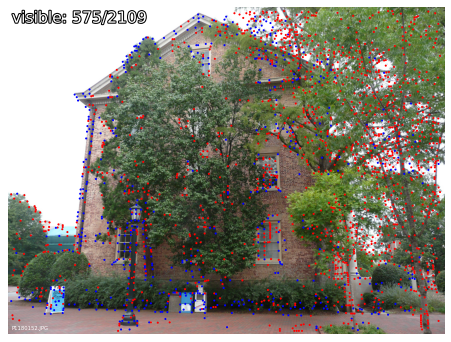

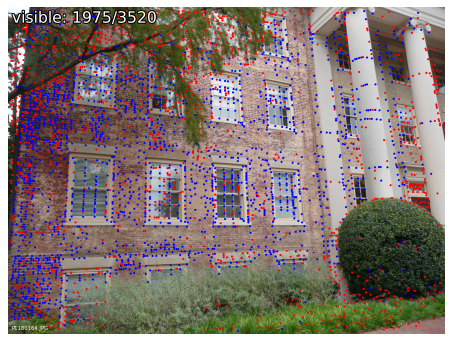

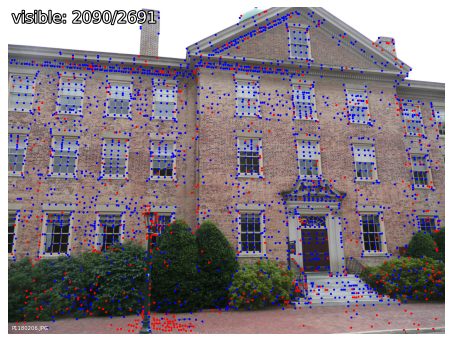

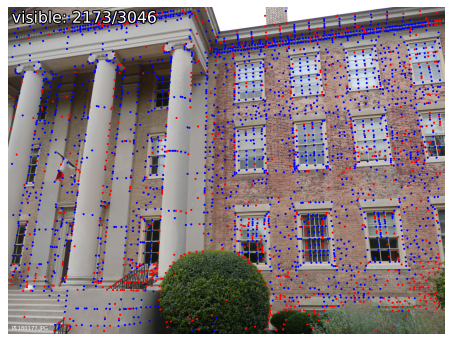

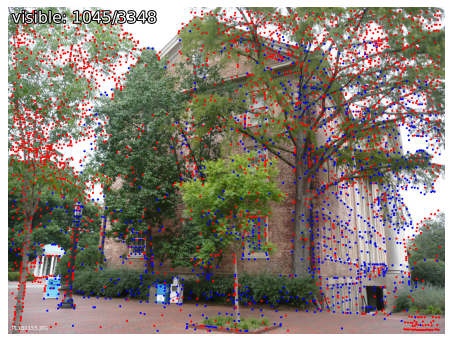

In [10]:
visualization.visualize_sfm_2d(model, images, color_by="visibility", n=5)

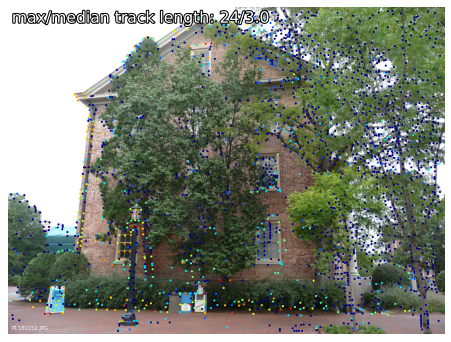

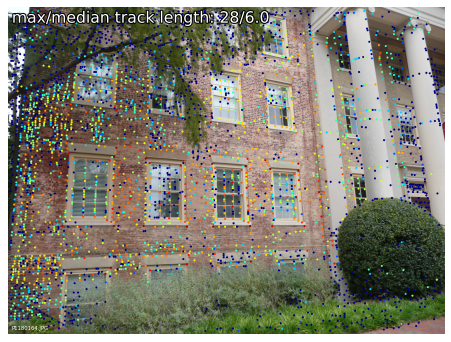

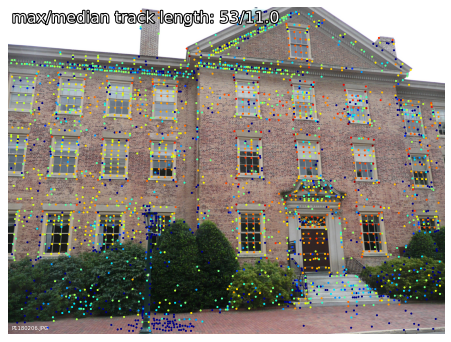

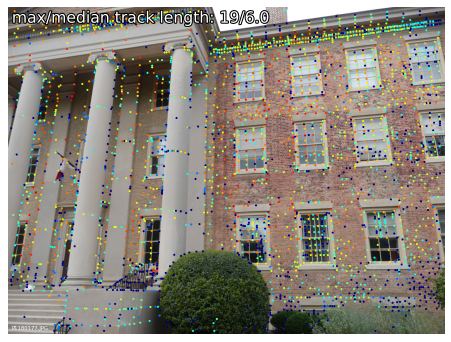

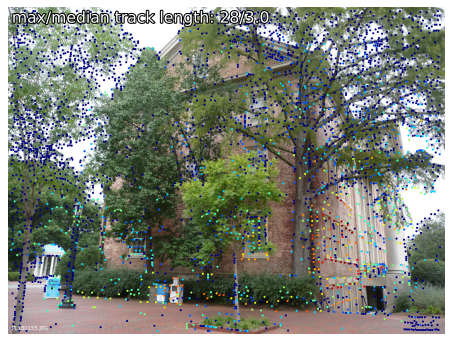

In [11]:
visualization.visualize_sfm_2d(model, images, color_by="track_length", n=5)

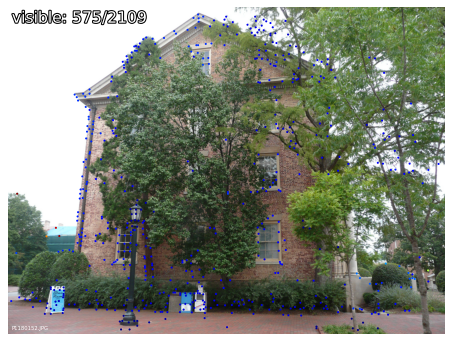

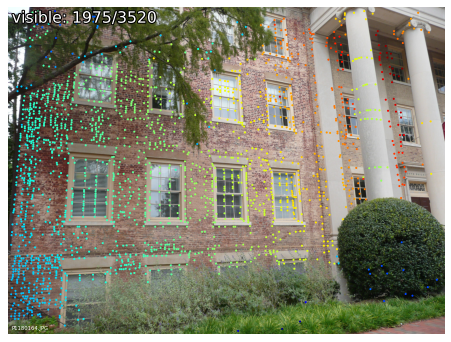

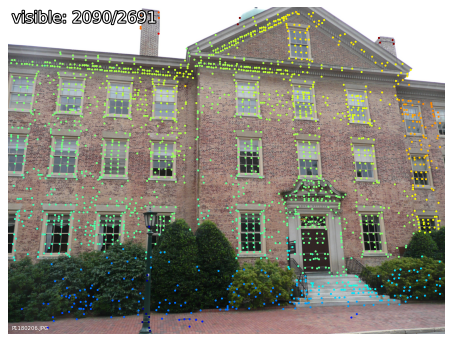

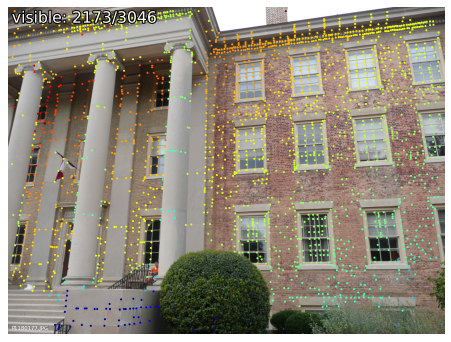

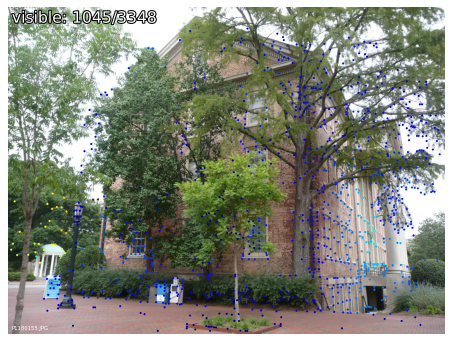

In [12]:
visualization.visualize_sfm_2d(model, images, color_by="depth", n=5)